<div style="text-align: center; padding: 20px;">
    <span style="font-size: 24px; font-weight: bold; text-decoration: underline;">
        Data Integration Project: Neo4j
    </span>
</div>

<div style="text-align: center; font-size: 18px; line-height: 1.5;">
    Aurélien VERDIER, Inthushan SUTHAKARAN<br>
    2024/2025<br>
</div>
</div>
</div>
</div>
</div>

---

## 1. Project Initialization: Downloading and Importing Libraries


In this part we will download and import the required library.

In [1]:
!pip install neo4j
!pip install py2neo 

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from py2neo import Graph

## 2. Loading and Integrating Data into Neo4j
In this section of the code, our objective is to load the data from the CSV file and integrate it into the Neo4j database. The goal is to establish relationships between the nodes so that they can be displayed in the second part of the code. 

To establish a connection with the Neo4j database, we first need to create a project in the Neo4j application, which will allow us to open a connection between this notebook and the Neo4j library.

In [3]:
# connection to the neo4j database created
URI = "neo4j://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "123456789"

In [5]:
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

#function to load a movie data into the neo4j database and creating nodes relashionship for genre,country and year
def load_movie_data(tx, movie):
    query = (
        "MERGE (m:Movie {title: $title}) "
        "SET m.worldwide_gross = $worldwide_gross, m.domestic_gross = $domestic_gross, m.foreign_gross = $foreign_gross, "
        "    m.rating = $rating, m.vote_count = $vote_count, m.year = $year "
        "FOREACH (genre IN $genres | MERGE (g:Genre {name: genre}) MERGE (m)-[:HAS_GENRE]->(g)) "
        "FOREACH (country IN $countries | MERGE (c:Country {name: country}) MERGE (m)-[:PRODUCED_IN]->(c)) "
        "MERGE (y:Year {value: $year}) MERGE (m)-[:RELEASED_IN_YEAR]->(y)"
    )
    tx.run(query, **movie)

# Function to import movie data from a CSV file into Neo4j
def import_movies():
    # take the data from the csv file
    data = pd.read_csv("../Data/cleaned_data_integration.csv")
    # Convert the 'Genres' and 'Production_Countries' columns into lists
    data['Genres'] = data['Genres'].apply(lambda x: x.split(', ') if pd.notnull(x) else [])
    data['Production_Countries'] = data['Production_Countries'].apply(lambda x: x.split(', ') if pd.notnull(x) else [])
    # Open a Neo4j session and write data to the database
    with driver.session() as session:
        for _, row in data.iterrows():
            movie = {
                "title": row['Release Group'],
                "worldwide_gross": row['$Worldwide'],
                "domestic_gross": row['$Domestic'],
                "foreign_gross": row['$Foreign'],
                "rating": float(row['Rating'].split('/')[0]) if pd.notnull(row['Rating']) else None,
                "vote_count": row['Vote_Count'],
                "year": row['Year'],
                "genres": row['Genres'],
                "countries": row['Production_Countries']
            }
            session.execute_write(load_movie_data, movie)

    print("Data imported with sucess")
#Execution block
import_movies()
driver.close()#close the connection


Data imported with sucess


## 3. Creating and Analyzing Relationships between Nodes in Neo4j

In the following code, we create four queries that display relationships between nodes within the Neo4j database established in the previous section. Given the high data density in our database, we limit the graph to only 15 values in order to maintain readability and clarity.

With this sample of values, detailed analysis is limited, except for the second query, which focuses on countries and their highest-rated movies, and the third query, which examines movies with the most votes and their associated countries. The other queries are interesting for further analysis with a larger dataset, but they still allow us to observe the nodes created and the relationships between them.

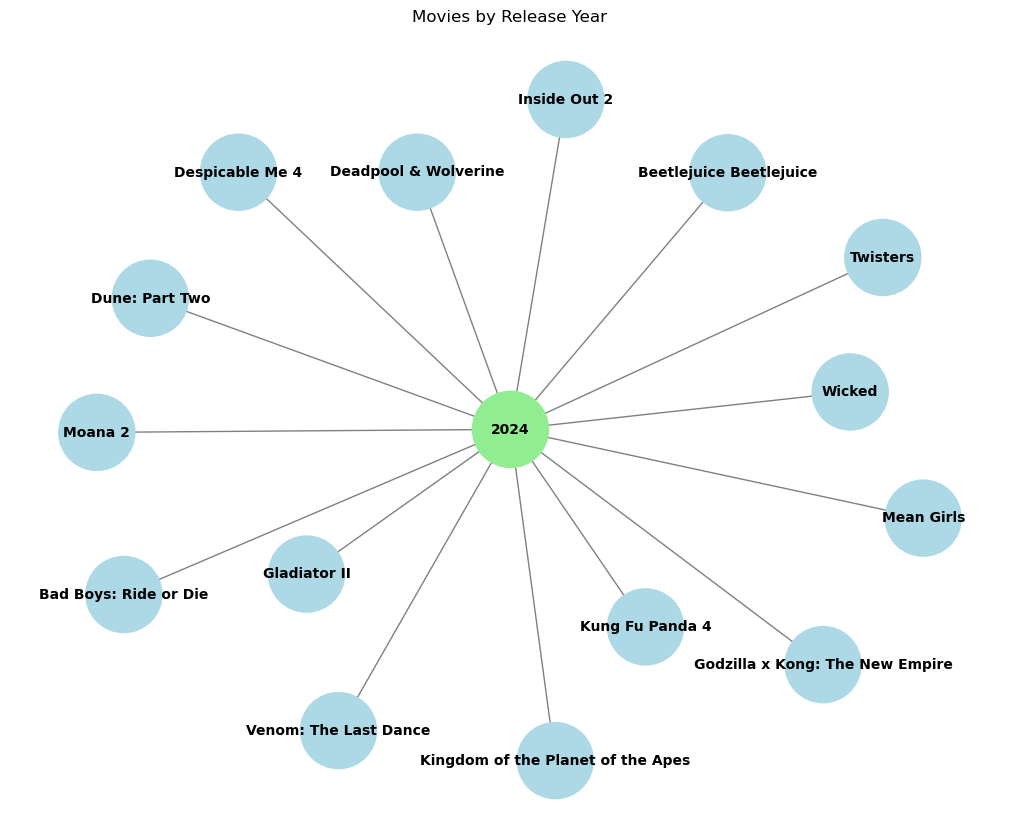

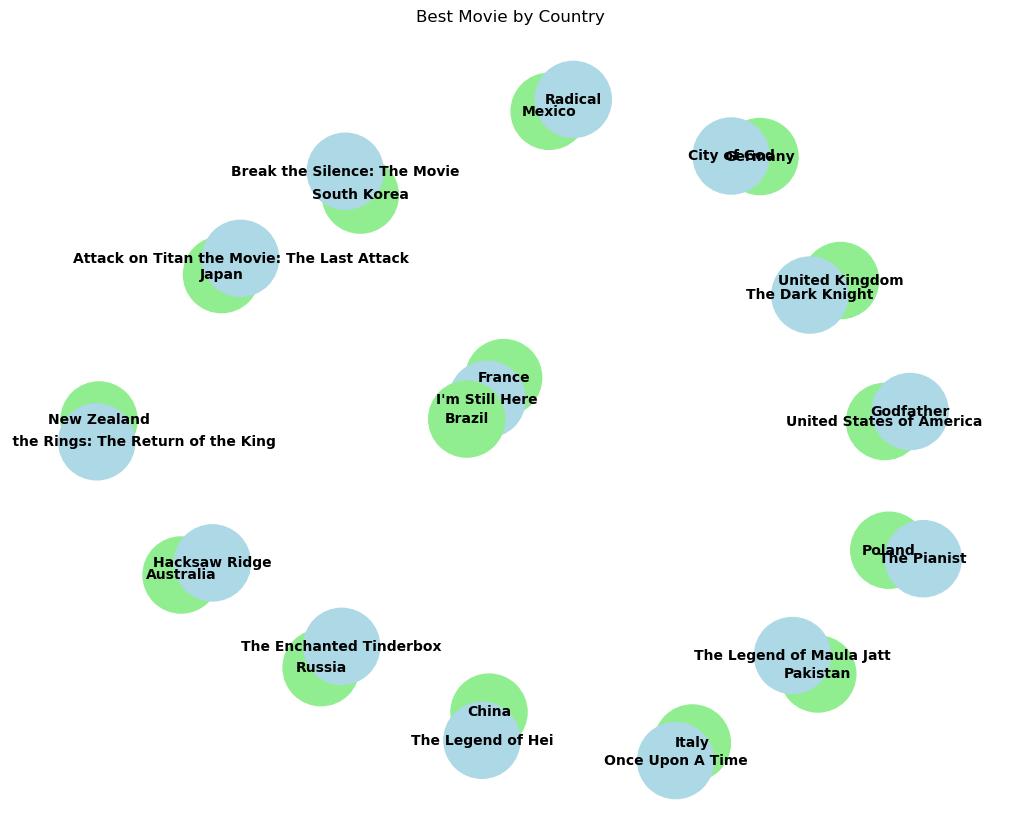

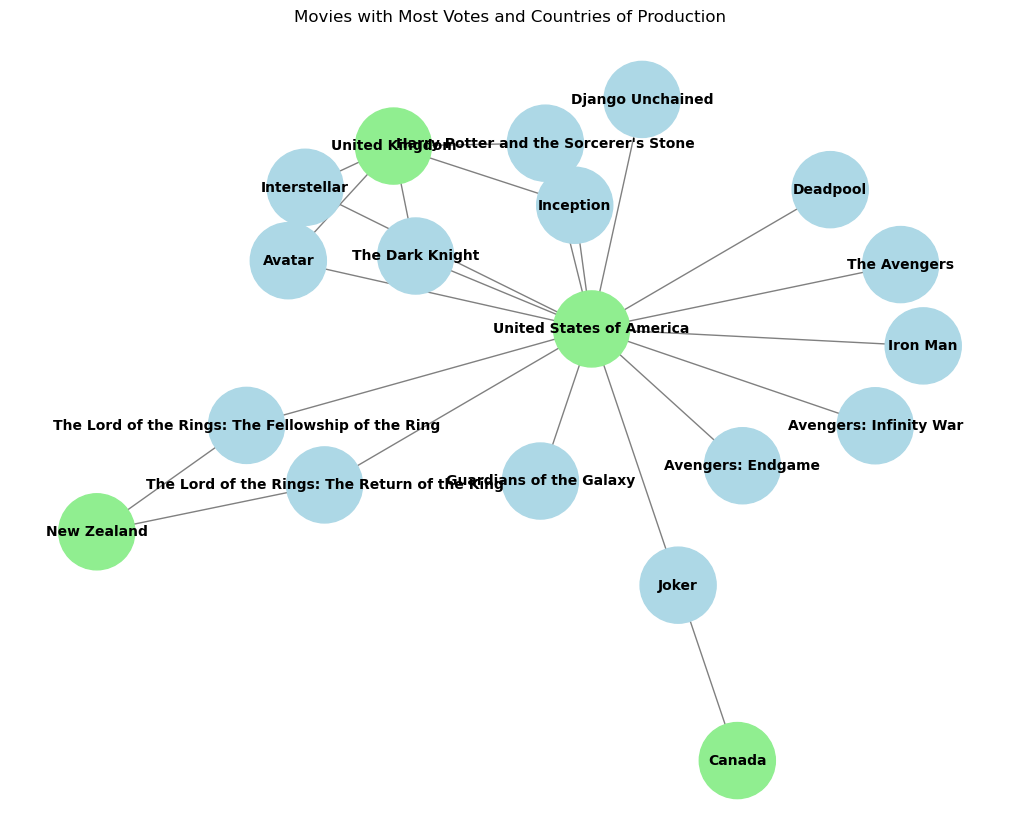

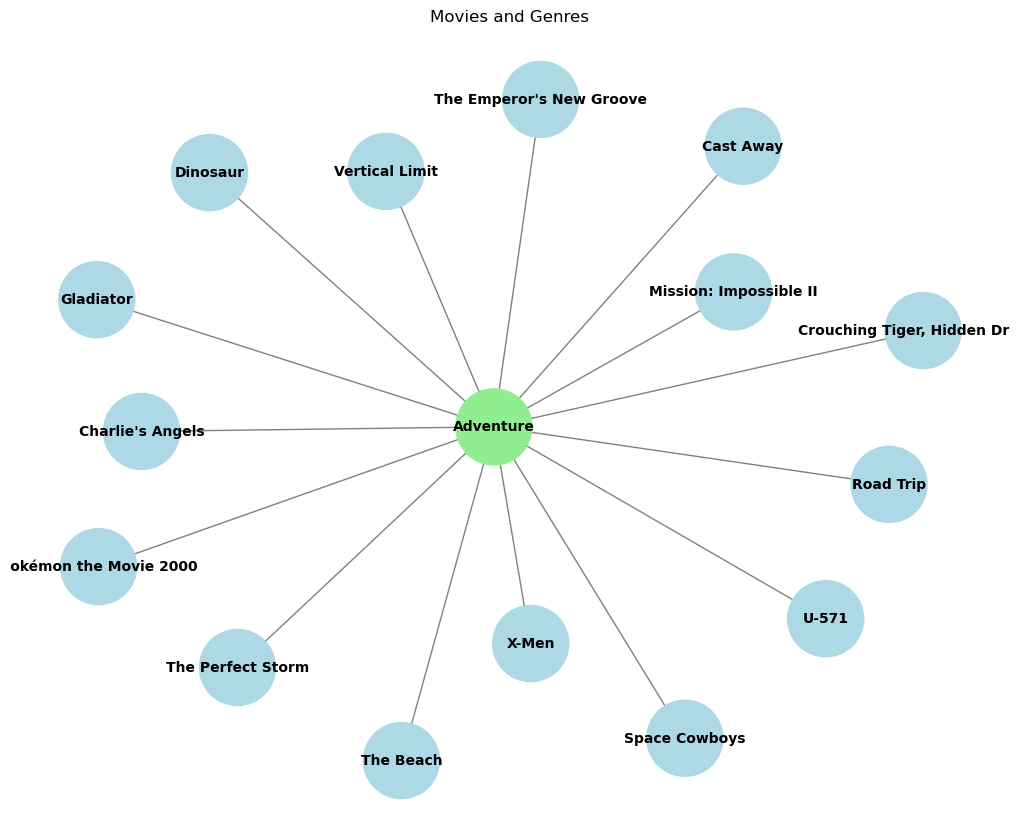

In [8]:
# Initialize the connection to Neo4j using URI and authentication details
graph = Graph(URI, auth=(USERNAME, PASSWORD))

# Define queries to fetch and visualize movie data from Neo4j

# Query 1: Retrieve movies by release year, ordered by the most recent years
query1 = """
MATCH (m:Movie)-[:RELEASED_IN_YEAR]->(y:Year)
RETURN m.title AS Movie, y.value AS Year
ORDER BY y.value DESC
LIMIT 15
"""

# Query 2: Retrieve the best-rated movie for each country
query2 = """
MATCH (m:Movie)-[:PRODUCED_IN]->(c:Country)
WITH c.name AS Country, m.title AS Movie, m.rating AS Rating
ORDER BY Rating DESC
RETURN Country, collect(Movie)[0] AS BestMovie, collect(Rating)[0] AS BestRating
LIMIT 15
"""

# Query 3: Retrieve movies with the most votes, along with their production countries
query3 = """
MATCH (m:Movie)-[:PRODUCED_IN]->(c:Country)
RETURN m.title AS Movie, m.vote_count AS Votes, collect(c.name) AS Countries
ORDER BY m.vote_count DESC
LIMIT 15
"""

# Query 4: Retrieve movies and their associated genres
query4 = """
MATCH (m:Movie)-[:HAS_GENRE]->(g:Genre)
RETURN m.title AS Movie, g.name AS Genre
LIMIT 15
"""

# Execute each query and store the results
results1 = graph.run(query1)
results2 = graph.run(query2)
results3 = graph.run(query3)
results4 = graph.run(query4)

# Function to plot the graph visualization
def plot_graph(G, title):
    """
    This function plots the graph visualization using NetworkX.
    It colors nodes based on their type (Movie or other) and sets other visualization parameters.
    """
    plt.figure(figsize=(10, 8)) 
    node_color = ['lightblue' if G.nodes[node].get('type') == 'Movie' else 'lightgreen' for node in G.nodes]
    nx.draw(G, with_labels=True, node_size=3000, node_color=node_color, font_size=10, font_weight="bold", edge_color="gray")
    plt.title(title)  
    plt.show()  

# Create and visualize the first graph 
G1 = nx.Graph()
for record in results1:
    G1.add_node(record["Movie"], type="Movie", year=record["Year"]) 
    G1.add_node(record["Year"], type="Year")  
    G1.add_edge(record["Movie"], record["Year"], relation="RELEASED_IN_YEAR")  
plot_graph(G1, "Movies by Release Year")  # Plot the first graph

# Create and visualize the second graph (Best-rated movie by country)
G2 = nx.Graph()
for record in results2:
    country_node = record["Country"]
    best_movie = record["BestMovie"]
    best_rating = record["BestRating"]
    G2.add_node(country_node, type="Country") 
    G2.add_node(best_movie, type="Movie", rating=best_rating)  
    G2.add_edge(country_node, best_movie, relation="BEST_MOVIE")  
plot_graph(G2, "Best Movie by Country")  # Plot the second graph

# Create and visualize the third graph (Movies with most votes and their production countries)
G3 = nx.Graph()
for record in results3:
    G3.add_node(record["Movie"], type="Movie", votes=record["Votes"]) 
    for country in record["Countries"]:
        G3.add_node(country, type="Country")  
        G3.add_edge(record["Movie"], country, relation="PRODUCED_IN")  
plot_graph(G3, "Movies with Most Votes and Countries of Production")  # Plot the third graph

# Create and visualize the fourth graph 
G4 = nx.Graph()
for record in results4:
    G4.add_node(record["Movie"], type="Movie")  
    G4.add_node(record["Genre"], type="Genre")  
    G4.add_edge(record["Movie"], record["Genre"], relation="HAS_GENRE")  
plot_graph(G4, "Movies and Genres")  # Plot the fourth graph
